<a href="https://colab.research.google.com/github/Smjfirna/Arsitektur-Compration/blob/main/Alexnet%20final/50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Preprocessing
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

#Model dan Augmentasi
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout,BatchNormalization
import os
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop

# Evaluasi
#import torch
#import torchvision.models as models
#from thop import profile
from sklearn.metrics import confusion_matrix, classification_report

#Visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"smjayyy","key":"07729aa6a210c0f9baaeed1cf96a6a3b"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
##link dataset in Kaggle.com
!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset

Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 97% 156M/161M [00:01<00:00, 185MB/s]
100% 161M/161M [00:01<00:00, 146MB/s]


In [5]:
!unzip -q corn-or-maize-leaf-disease-dataset.zip -d /content

In [6]:
dataset_dir = '/content/data'

In [7]:
print(os.listdir(dataset_dir))

['Blight', 'Healthy', 'Common_Rust', 'Gray_Leaf_Spot']


In [8]:
IMAGE_SIZE_alexnet = 227

In [9]:
def make_data(label, DIR, img_list, label_list):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, img)
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMAGE_SIZE_alexnet, IMAGE_SIZE_alexnet))
        img_list.append(np.array(img))
        label_list.append(str(label))

In [10]:
X = []
Z = []

In [11]:
for i, class_name in enumerate(['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight']):
    class_dir = os.path.join(dataset_dir, class_name)
    make_data(class_name, class_dir, X, Z)

100%|██████████| 1146/1146 [00:05<00:00, 202.65it/s]


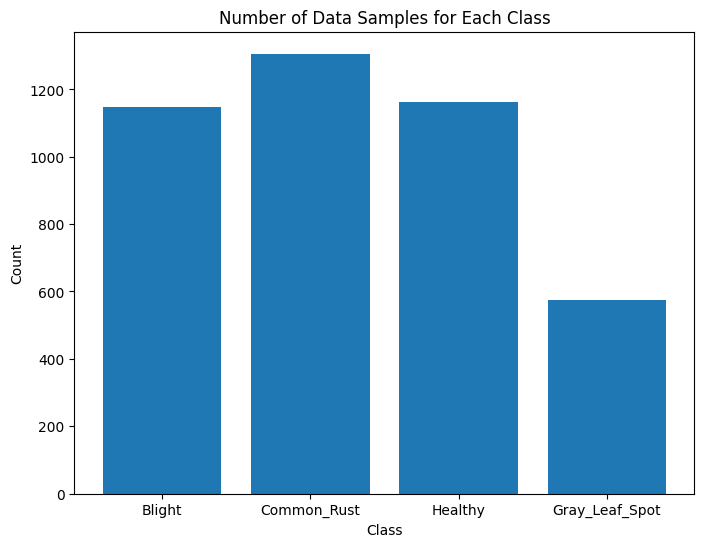

In [12]:
import matplotlib.pyplot as plt

# Menghitung jumlah data untuk setiap kelas
class_counts = {class_name: Z.count(class_name) for class_name in set(Z)}

# Menampilkan visualisasi jumlah data
plt.figure(figsize=(8, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Data Samples for Each Class')
plt.show()

In [13]:
le = LabelEncoder()
Y = le.fit_transform(Z)
Y = to_categorical(Y, num_classes=len(le.classes_))

# Konversi ke array numpy
X = np.array(X)

# Memisahkan data menjadi data latih dan data uji
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Jumlah Data Train adalah :", len(X_train))
print("Jumlah Data Test adalah :", len(X_test))

Jumlah Data Train adalah : 3350
Jumlah Data Test adalah : 838


In [14]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train)

In [15]:
model_alexnet = tf.keras.models.Sequential([
        # 1st conv
        Conv2D(96, (11,11), strides=(4,4), activation='relu', input_shape=(IMAGE_SIZE_alexnet, IMAGE_SIZE_alexnet, 3)),
        BatchNormalization(),
        MaxPooling2D(2, strides=(2,2)),
        # 2nd conv
        Conv2D(256, (11,11), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        # 3rd conv
        Conv2D(384, (3,3), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        # 4th conv
        Conv2D(384, (3,3), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        # 5th Conv
        Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D(2, strides=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dense(4096, activation='relu'),
        Dense(4, activation='softmax')
    ])

model_alexnet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

model_alexnet.summary()

history_alexnet = model_alexnet.fit(datagen.flow(X_train, Y_train), epochs=50, validation_data=(X_test, Y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 55, 55, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       2973952   
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                        

27/27 [==============================] - 1s 32ms/step


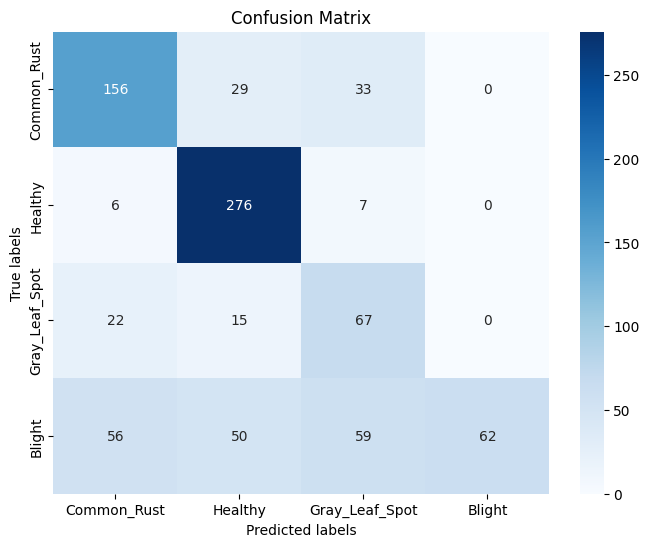


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.72      0.68       218
           1       0.75      0.96      0.84       289
           2       0.40      0.64      0.50       104
           3       1.00      0.27      0.43       227

    accuracy                           0.67       838
   macro avg       0.70      0.65      0.61       838
weighted avg       0.75      0.67      0.64       838



In [16]:
Y_pred = model_alexnet.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

conf_matrix = confusion_matrix(Y_true, Y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'], yticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(Y_true, Y_pred_classes)

print("\nClassification Report:")
print(class_report)